In [128]:
#Imports

import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [129]:
#Read the dataset

from google.colab import files 
uploaded = files.upload()
import io
df = pd.read_csv(io.BytesIO(uploaded['TATAPOWER.NS.csv']))

corr1 = df['Open'].corr(df['Close'])
corr2 = df['Close'].corr(df['Volume'])
corr3 = df['Close'].corr(df['High'])

print("Correlation between Open & Close:",corr1)
print("Correlation between Volume & Close:",corr2)
print("Correlation between High & Close:",corr3)
df.head()

Saving TATAPOWER.NS.csv to TATAPOWER.NS (7).csv
Correlation between Open & Close: 0.9992904531180177
Correlation between Volume & Close: 0.30576907818730586
Correlation between High & Close: 0.9996803744618018


,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-01-01,11.580205,11.662232,11.488529,11.628456,5.920809,33160.0
1,1996-01-02,11.628456,11.739433,11.396852,11.483704,5.847106,176162.0
2,1996-01-03,11.483704,11.599506,11.392027,11.411327,5.810253,104661.0
3,1996-01-04,11.411327,11.387202,11.155598,11.242449,5.724268,77718.0
4,1996-01-05,11.242449,11.483704,11.097697,11.464403,5.837279,113469.0


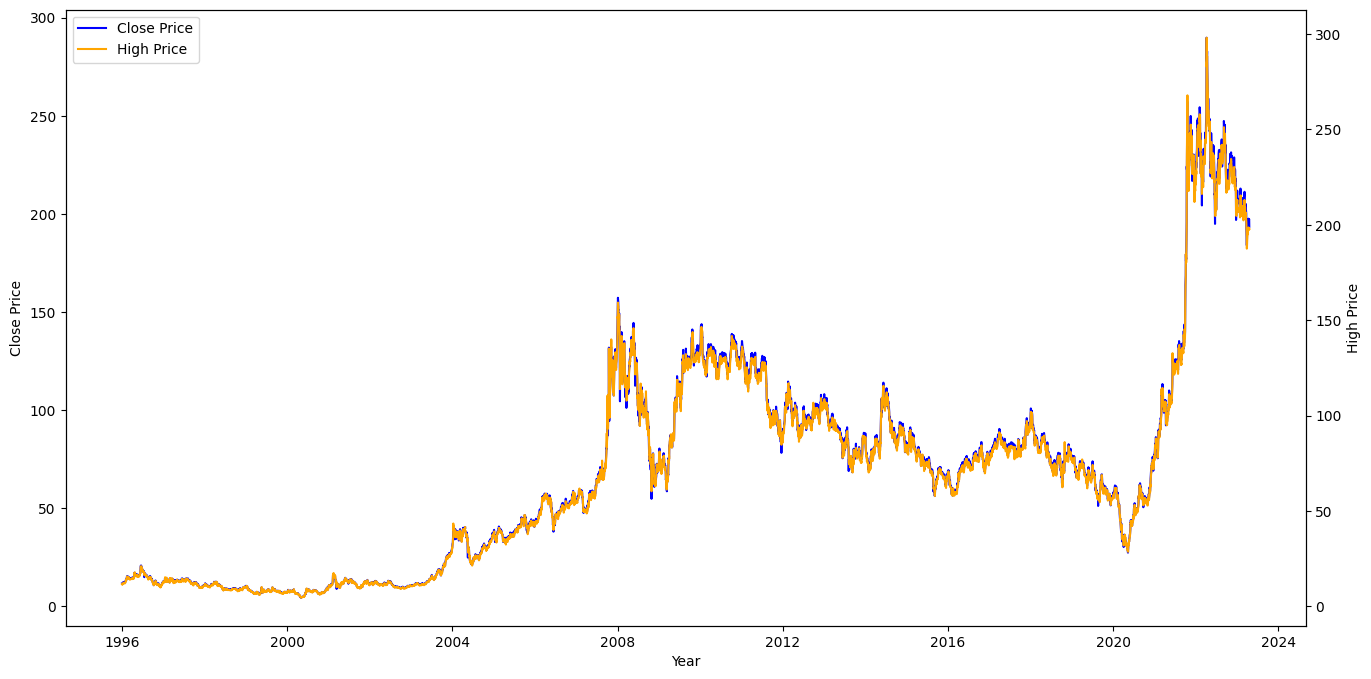

In [130]:
# Visualize the closing prices

df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.xlabel("Year")
ax1 = plt.subplot()
l1, = ax1.plot(df["Close"], color='blue')
plt.ylabel("Close Price")
ax2 = ax1.twinx()
l2, = ax2.plot(df["High"], color='orange')
plt.ylabel("High Price")

plt.legend([l1, l2], ["Close Price", "High Price"])

plt.show()

In [131]:
# Preprocessing the data

df = df.dropna()

data=df.sort_index(ascending=True,axis=0)  # Sorting in asending order of the date

a= len(df)
reduced_df=pd.DataFrame(index=range(0,a),columns=['Date','Close','High'])  # Creating new dataset with only Date & Close price columns
print("Size of the reduced data frame with features considered:",reduced_df.shape)
for i in range(0,len(data)):
    reduced_df["Date"][i]=data['Date'][i]
    reduced_df["Close"][i]=data["Close"][i]
    reduced_df["High"][i]=data["High"][i]

reduced_df.head()

Size of the reduced data frame with features considered: (6862, 3)


,Date,Close,High
0,1996-01-01 00:00:00,11.628456,11.662232
1,1996-01-02 00:00:00,11.483704,11.739433
2,1996-01-03 00:00:00,11.411327,11.599506
3,1996-01-04 00:00:00,11.242449,11.387202
4,1996-01-05 00:00:00,11.464403,11.483704


In [132]:
reduced_df.index=reduced_df.Date             # Making date column as the index
reduced_df.drop("Date",axis=1,inplace=True)  # Droping time stamp 00:00:00 from Date column

final_dataset=reduced_df.values    # Creating an array of close values using Date column as index

print("Dataset shape with only Values considered excluding date:", final_dataset.shape)
print("Dataset with only Values considered excluding date:\n",final_dataset)

Dataset shape with only Values considered excluding date: (6862, 2)
Dataset with only Values considered excluding date:
 [[11.628456 11.662232]
 [11.483704 11.739433]
 [11.411327 11.599506]
 ...
 [196.949997 197.600006]
 [197.25 198.199997]
 [193.449997 197.75]]


In [133]:
# Splitting the data into Train & test by 80-20
train_data, test_data = train_test_split(final_dataset, test_size=0.2,shuffle=False)

print("Size of Train Data:",train_data.shape)
print("Train Data:\n", train_data)
print("Size of Test Data:",test_data.shape)
print("Test Data:\n", test_data)

Size of Train Data: (5489, 2)
Train Data:
 [[11.628456 11.662232]
 [11.483704 11.739433]
 [11.411327 11.599506]
 ...
 [80.400002 82.900002]
 [81.849998 82.5]
 [79.949997 82.900002]]
Size of Test Data: (1373, 2)
Test Data:
 [[78.150002 80.5]
 [77.25 78.75]
 [77.800003 78.650002]
 ...
 [196.949997 197.600006]
 [197.25 198.199997]
 [193.449997 197.75]]


In [134]:
scale=MinMaxScaler(feature_range=(0,1))
scaled_data=scale.fit_transform(train_data)

scaled_data_test=scale.fit_transform(test_data)
print("Train data shape scaled to 0-1:", scaled_data.shape)
print("Test data shape scaled to 0-1:",scaled_data_test.shape)

Train data shape scaled to 0-1: (5489, 2)
Test data shape scaled to 0-1: (1373, 2)


In [135]:
#Normalize the new filtered dataset

x_train_data,y_train_data=[],[]
x_train_data = scaled_data
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))  # converting train data into 3D array since LSTM needs 3D Tensor
#print("Scaled Data Shape:",scaled_data.shape)
y_train_data = [i[0] for i in scaled_data]
print("Training Data set Shape:",x_train_data.shape)
#print(x_train_data)
#print(y_train_data)
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
#data.head()

Training Data set Shape: (5489, 2, 1)


In [136]:
#Build and train the LSTM model

lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

5489/5489 - 21s - loss: 9.0360e-04 - 21s/epoch - 4ms/step


In [137]:
X_test=[]

X_test=np.array(scaled_data_test)  
print("Testing Data set Shape:",X_test.shape)

Testing Data set Shape: (1373, 2)


In [138]:
#Make a prediction using the LSTM model

predicted_closing_price=lstm_model.predict(X_test)
z = np.zeros((len(predicted_closing_price),1))

predicted_closing_price = np.append(predicted_closing_price, z, axis=1)
#print(predicted_closing_price)
predicted_closing_price=scale.inverse_transform(predicted_closing_price)

predicted_closing_price = np.delete(predicted_closing_price, 1, 1)  # delete second column of zeros
print("Predicted Closing Price Sahep:",predicted_closing_price.shape)

43/43 [==============================] - 1s 2ms/step
Predicted Closing Price Sahep: (1373, 1)


In [139]:
#lstm_model.save("saved_model.h5")

Text(0, 0.5, 'Closing Price')

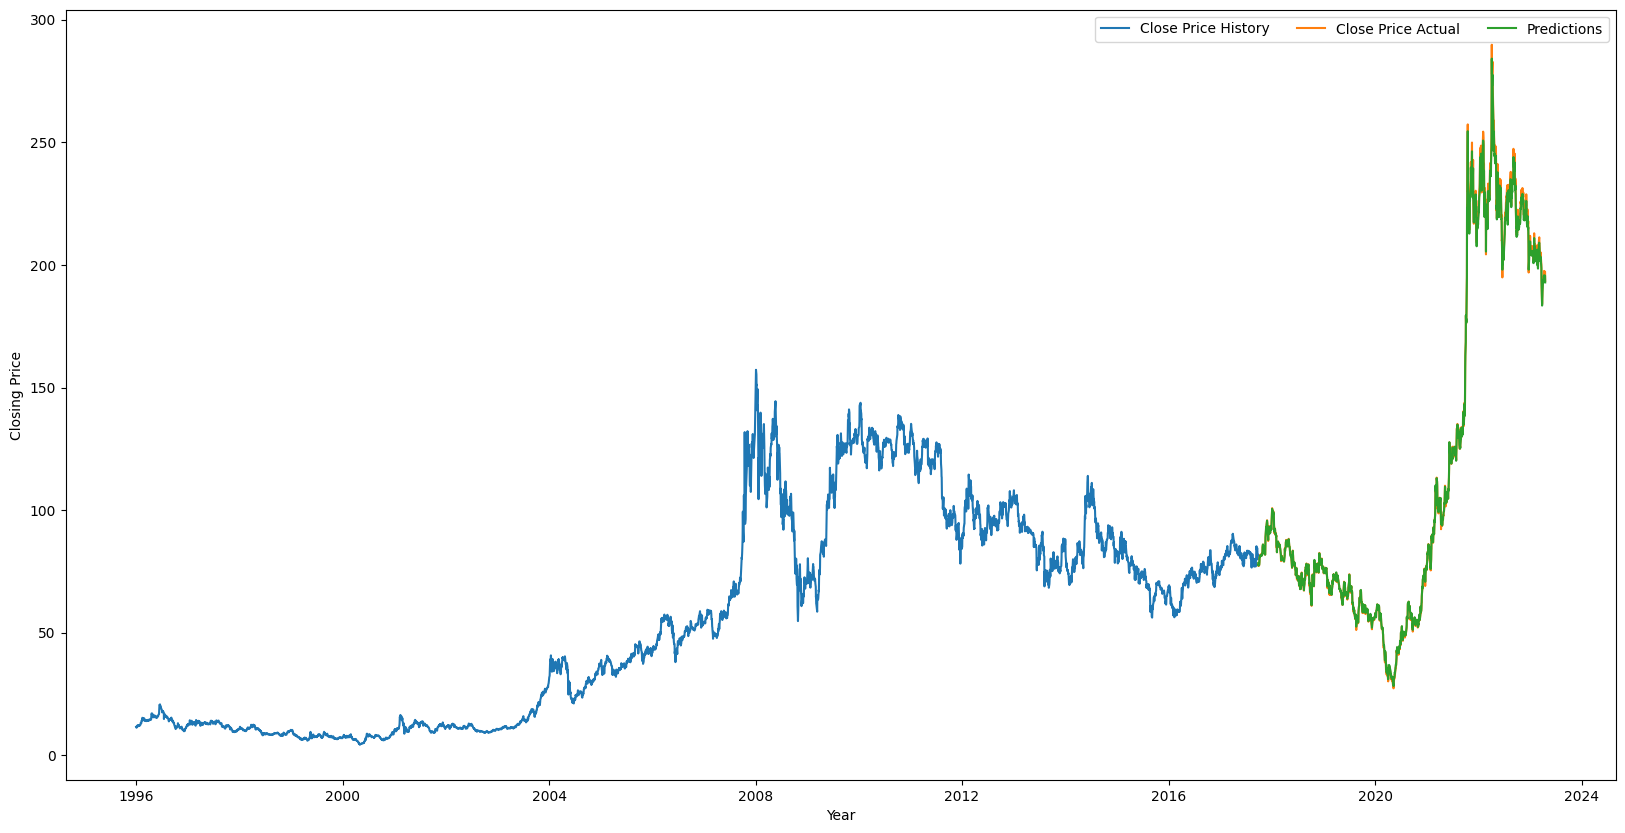

In [140]:
#Visualize the results

train_data=reduced_df[:train_data.shape[0]]
test_data=reduced_df[train_data.shape[0]:]

test_data['Predictions']=predicted_closing_price

#print(test_data)

plt.plot(train_data["Close"], label = "Close Price History")
plt.plot(test_data["Close"], label = "Close Price Actual")
plt.plot(test_data["Predictions"], label = "Predictions")
plt.legend(ncol=3, loc="upper right")
plt.xlabel("Year")
plt.ylabel("Closing Price")




In [141]:
#print(test_data)

test_data['Score_diff'] = test_data['Predictions'] - test_data['Close']

test_data

var = round(test_data['Score_diff'].var(),3)
mean = round(test_data['Score_diff'].mean(),3)

print("Avg differences between actual & predicted :", mean)

print("Variance between actual & predicted :", var)

pd.options.mode.chained_assignment = None 


Avg differences between actual & predicted : -0.458
Variance between actual & predicted : 1.355
